In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib.patheffects as path_effects
from matplotlib import rc
import pickle
from tqdm import tqdm
import proplot as pplt

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
from spritz_diagram import *
import cfg
import os

save = 'figures/paper_plots/'

#set figure font sizes for readability
pplt.rc.update({
    'font.size': 10
})

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
def evaluate_peaks(cutoff=0.2, c=None, t=None, 
                  cutoff_peak=None, cutoff_trough=None,
                  period=None, skip_first=None):
    '''
    Determine which peaks and troughs are valid
    cutoff: the c concentration that has to be passed to be considered
        a true peak or trough
    peaks, troughs: pass manually if wanting to use saved data
    cutoff_peak, cutoff_trough: if passed, these take precedence
        individual thresholds for what counts for peaks and troughs
    period, skip_first_spikes: if setting these, we can skip information
        before the first spritzes
    '''
    if c is None:
        c = cfg.c
    if t is None:
        t = cfg.t
    
    peaks = scipy.signal.find_peaks(c)[0]
    troughs = scipy.signal.find_peaks(-c)[0]
    
    if cutoff_peak is None:
        cutoff_peak = cutoff
    if cutoff_trough is None:
        cutoff_trough = cutoff
        
    if period is not None and skip_first is not None:
        start_idx = np.argmax(t > skip_first*(period+1))
        peaks = peaks[peaks > start_idx]
        troughs = troughs[troughs > start_idx]
        
    #Remove peaks and troughs not past the cutoff
    peaks = peaks[c[peaks] > cutoff_peak]
    troughs = troughs[c[troughs] < cutoff_trough]
    
    if len(peaks) == 0:
        return []
    
    #Remove troughs that happen before first peak
    troughs = troughs[troughs > peaks.min()]

    # Find valid_peaks (those with a trough between them and the last peak)
    valid_peaks = []
    peak_idx = 0
    trough_idx = -1
    while peak_idx < len(peaks):
        peak = peaks[peak_idx]
        valid_peaks.append(peak)

        # Find next trough
        next_troughs = np.argwhere(troughs > peak)
        # Both break statements go through if no more troughs happen after peaks
        if len(next_troughs) < 1:
            break
        next_trough_idx = next_troughs[0].item()
        if next_trough_idx <= trough_idx:
            break
        trough_idx = next_trough_idx
        next_trough = troughs[next_trough_idx]
        # print(next_trough)

        # Find next peak
        next_peaks = np.argwhere(peaks > next_trough)

        if len(next_peaks) < 1:
            break
        next_peak = next_peaks[0].item()
        peak_idx = next_peak

        # print(peak_idx)
    return valid_peaks


# Testing evaluate_peaks function and some example ranges

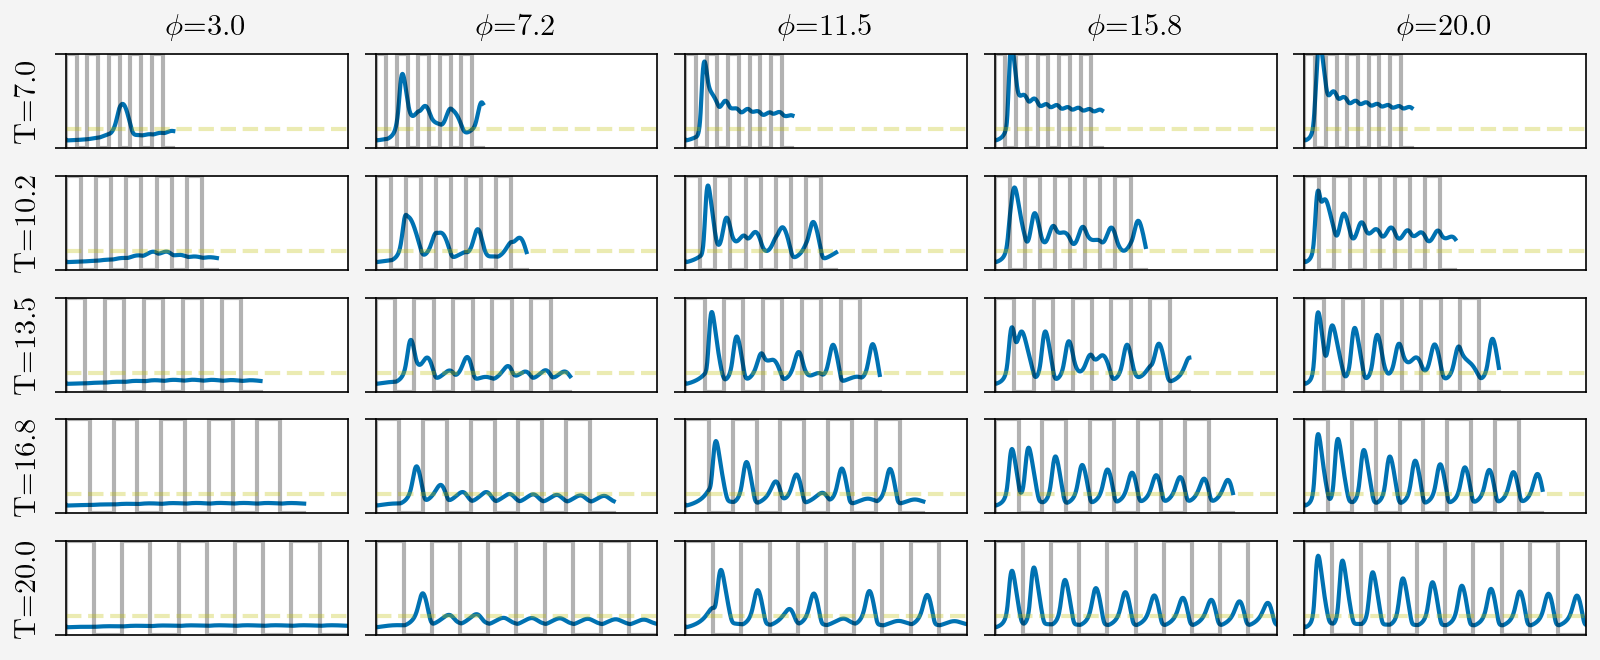

In [36]:
n = 5
m = 5
num_spikes = 10

set_init('c_t')

gluts = np.linspace(3, 20, n)
periods = np.linspace(7, 20, m)

fig, ax = pplt.subplots(nrows=m, ncols=n, refaspect=3, wspace=1, hspace=1,
                        figwidth=8)

for i, period in enumerate(periods):
    for j, glut in enumerate(gluts):
        run_spritz(period=period, conc=glut, osc_type=2, num=num_spikes)
        ax[i, j].plot(cfg.t, cfg.c)
        
        # Generate lines to show where spikes occur
        line_x = [0]
        line_y = [0]
        cur_x = 0
        cur_y = 0
        for _ in range(num_spikes):
            line_x.append(cur_x)
            line_y.append(1-cur_y)
            cur_y = 1 - cur_y
            cur_x = cur_x + period + 1
            line_x.append(cur_x)
            line_y.append(cur_y)
        ax[i, j].plot(line_x, line_y, c='k', alpha=0.3)
        ax[i, j].plot([0, 1000], [0.2, 0.2], c='y', alpha=0.3, linestyle='--')
        
        
ax.format(yticklabels=[], xticks=[],
         leftlabels=[f'T={period:.1f}' for period in periods],
         toplabels=[f'$\phi$={glut:.1f}' for glut in gluts],
         ylim=[0, 1], xlim=[0, 210])


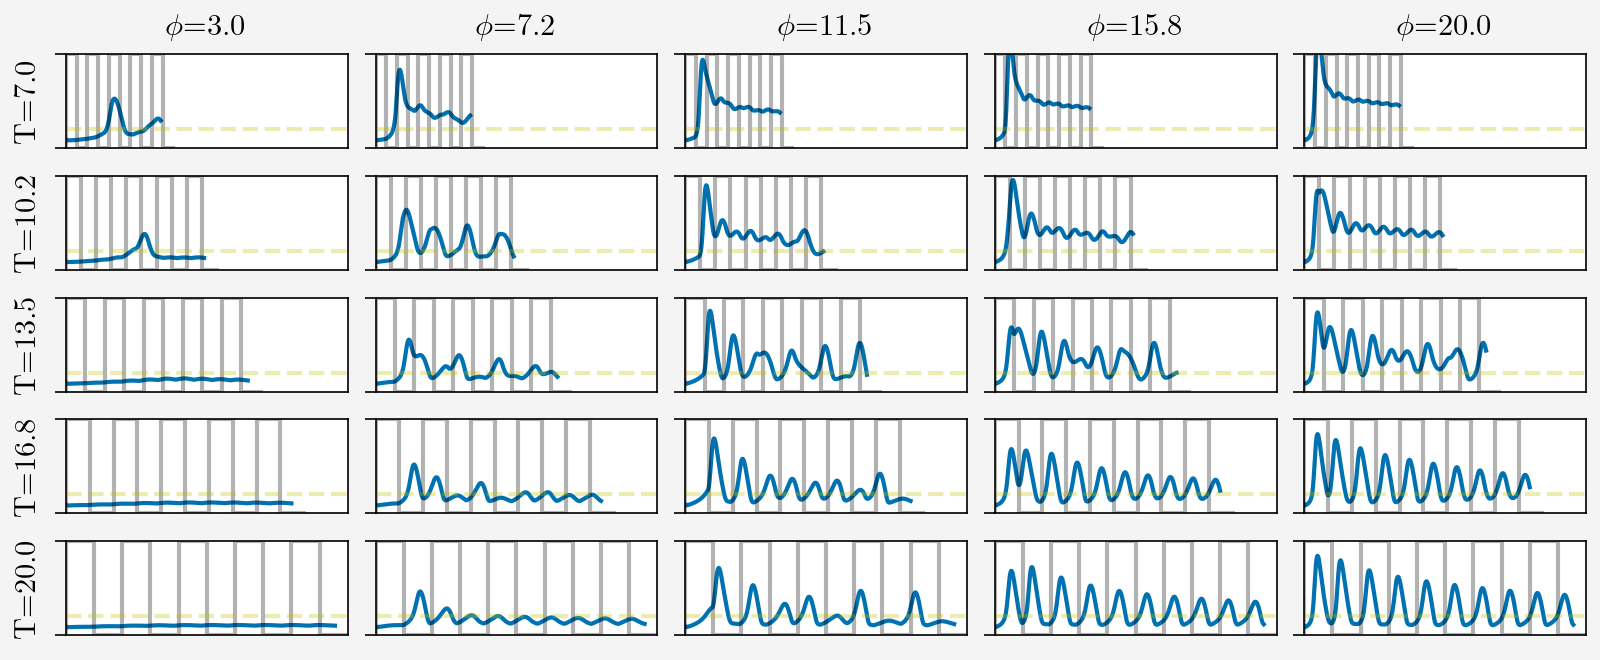

In [3]:
n = 5
m = 5
num_spikes = 10

set_init('c_t')

gluts = np.linspace(3, 20, n)
periods = np.linspace(7, 20, m)

fig, ax = pplt.subplots(nrows=m, ncols=n, refaspect=3, wspace=1, hspace=1,
                        figwidth=8)

for i, period in enumerate(periods):
    for j, glut in enumerate(gluts):
        run_spritz(period=period, conc=glut*20, osc_type=2, num=num_spikes,
                   dur=0.05)
        ax[i, j].plot(cfg.t, cfg.c)
        
        # Generate lines to show where spikes occur
        line_x = [0]
        line_y = [0]
        cur_x = 0
        cur_y = 0
        for _ in range(num_spikes):
            line_x.append(cur_x)
            line_y.append(1-cur_y)
            cur_y = 1 - cur_y
            cur_x = cur_x + period + 1
            line_x.append(cur_x)
            line_y.append(cur_y)
        ax[i, j].plot(line_x, line_y, c='k', alpha=0.3)
        ax[i, j].plot([0, 1000], [0.2, 0.2], c='y', alpha=0.3, linestyle='--')
        
        
ax.format(yticklabels=[], xticks=[],
         leftlabels=[f'T={period:.1f}' for period in periods],
         toplabels=[f'$\phi$={glut:.1f}' for glut in gluts],
         ylim=[0, 1], xlim=[0, 210])


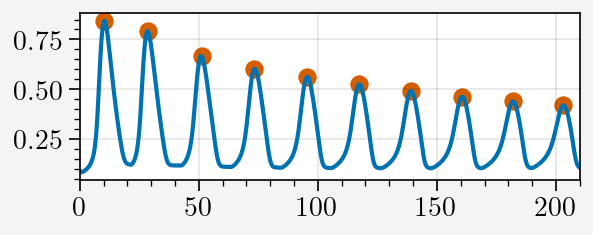

In [115]:
run_spritz(period=20, conc=20, osc_type=2)

fig, ax = pplt.subplots(refaspect=3)

ax.plot(cfg.t, cfg.c)
# ax.scatter(cfg.t[peaks], cfg.c[peaks])
# ax.scatter(cfg.t[troughs], cfg.c[troughs])

peaks = evaluate_peaks(cutoff=0.23)
ax.scatter(cfg.t[peaks], cfg.c[peaks])


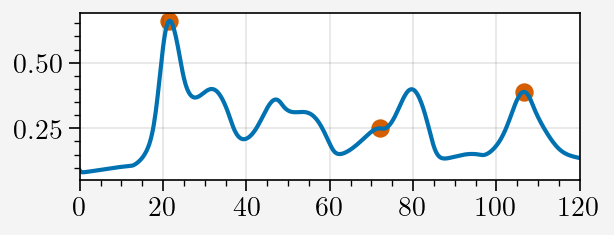

In [101]:
run_spritz(period=11, conc=8, osc_type=2)

fig, ax = pplt.subplots(refaspect=3)

ax.plot(cfg.t, cfg.c)
# ax.scatter(cfg.t[peaks], cfg.c[peaks])
# ax.scatter(cfg.t[troughs], cfg.c[troughs])

peaks = evaluate_peaks()
ax.scatter(cfg.t[peaks], cfg.c[peaks])


# Heatmap of response types

## Collect data

In [14]:
periods = np.linspace(10, 25, 100)
gluts = np.linspace(60, 300, 100)

data = {}
num_spikes = 10
for i, period in enumerate(tqdm(periods)):
    for j, glut in enumerate(gluts):
        key = f't{period:.1f}p{glut:.1f}'
        run_spritz(period=period, conc=glut, osc_type=2, num=num_spikes,
                  dur=0.05)
        
        data[key] = (cfg.t, cfg.c)
pickle.dump(data, open('data/spritz/10_spritz_summary_50ms', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [26:38<00:00, 15.99s/it]


## Example of heatmaps with different cutoffs

Cutoffs do not significantly change the 

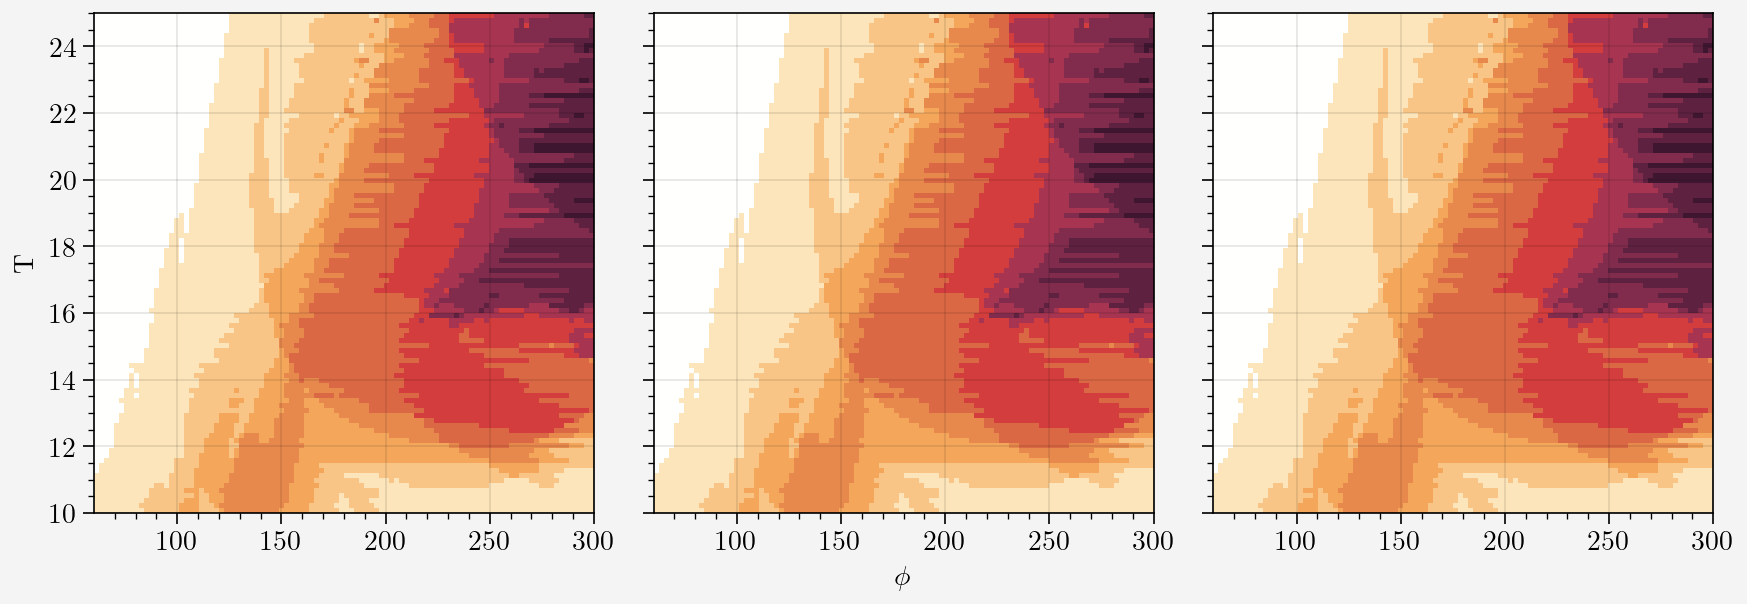

In [23]:
periods = np.linspace(10, 25, 100)
gluts = np.linspace(60, 300, 100)

fig, ax = pplt.subplots(ncols=3)
cutoffs = [0.25, 0.275, 0.3]

for i, cutoff in enumerate(cutoffs):
    hm = []
    for period in periods:
        row = []
        for glut in gluts:
            key = f't{period:.1f}p{glut:.1f}'
            t, c = data[key]
            peaks = evaluate_peaks(c=c, cutoff_peak=0.3, skip_first=2)
            row.append(len(peaks))
        hm.append(row)
    
    hm = np.flip(hm, axis=0)
    c = ax[i].imshow(hm, extent=(60, 300, 10, 25), aspect=16)
    # ax.colorbar(c)

ax.format(xlabel='$\phi$', ylabel='T')


### Confirmation of heatmap direction

Ensuring that flipping the heatmap in the correct way puts the x and y axes correctly

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 19946.28it/s]


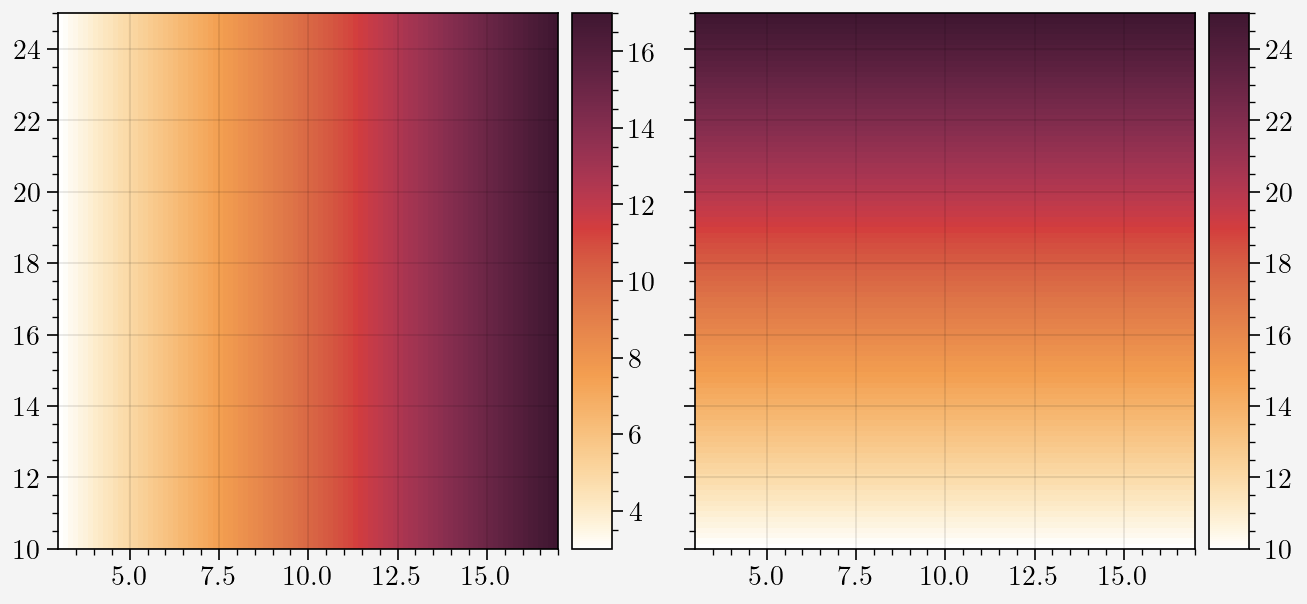

In [53]:
periods = np.linspace(10, 25, 100)
gluts = np.linspace(3, 17, 100)

fig, ax = pplt.subplots(ncols=2)

hm = []
hm2 = []
for i, period in enumerate(tqdm(periods)):
    row = []
    row2 = []
    for j, glut in enumerate(gluts):
        row.append(glut)
        row2.append(period)
    hm.append(row)
    hm2.append(row2)
    
# hm = np.flip(np.array(hm))
# hm = np.array(hm)
hm = np.flip(np.array(hm), axis=0)
# hm2 = np.array(hm2)
hm2 = np.flip(np.array(hm2), axis=0)

c = ax[0].imshow(hm, extent=(3, 17, 10, 25), aspect='equal')
ax[0].colorbar(c)

c = ax[1].imshow(hm2, extent=(3, 17, 10, 25), aspect='equal')
ax[1].colorbar(c)

## More selective visualization

* Use separate cutoffs for peaks and troughs (above 300uM for peak and below 200uM for trough)
* Start counting peaks after the first two spritzes are performed
    * This gets rid of what would seem to be an interesting feature (rounded darker shade in the top right) which is mostly just corresponding to whether the initial spikes are spread enough to generate two spikes

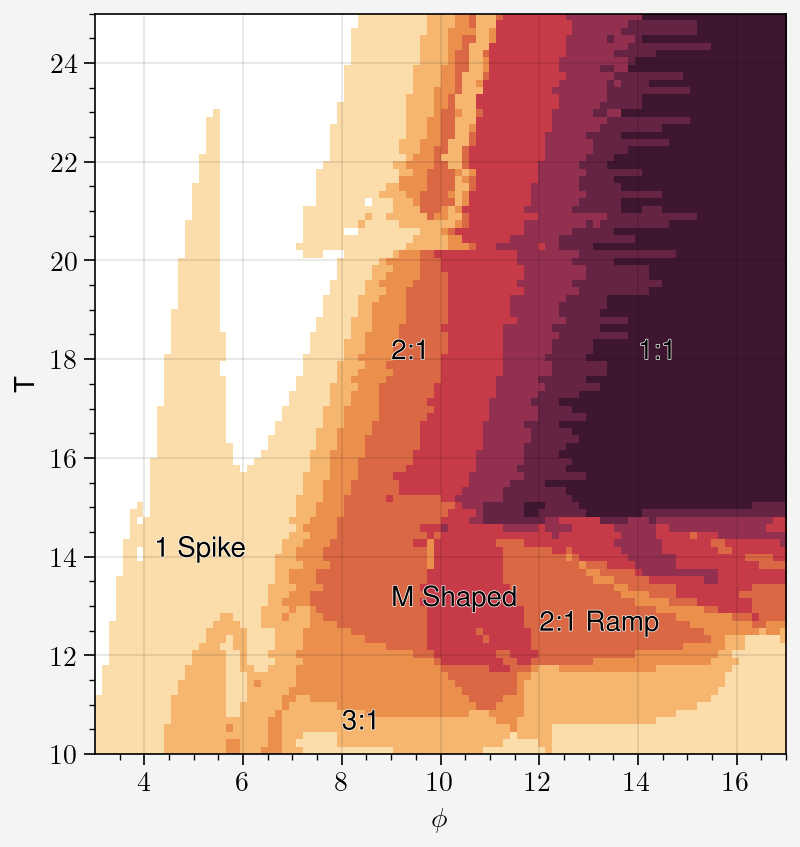

In [313]:
# data = pickle.load(open('data/spritz/12_spritz_summary', 'rb'))
data = pickle.load(open('data/spritz/10_spritz_summary', 'rb'))

periods = np.linspace(10, 25, 100)
gluts = np.linspace(3, 17, 100)

fig, ax = pplt.subplots(figwidth=4)
hm = []
for period in periods:
    row = []
    for glut in gluts:
        key = f't{period:.1f}p{glut:.1f}'
        # c = data[key]
        t, c = data[key]
        peaks = evaluate_peaks(c=c, t=t, cutoff_peak=0.3, cutoff_trough=0.2,
                              period=period, skip_first=2)
        row.append(len(peaks))
    hm.append(row)
hm = np.flip(hm, axis=0)


c = ax.imshow(hm, extent=(3, 17, 10, 25), aspect='equal')

text_labels = [
    (14, 18, '1:1'),
    (9, 18, '2:1'),
    (8, 10.5, '3:1'),
    (9, 13, 'M Shaped'),
    (4.2, 14, '1 Spike'),
    (12, 12.5, '2:1 Ramp')
]

for text in text_labels:
    txt = ax.text(text[0], text[1], text[2], c='black', fontweight='1000')
    txt.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

ax.format(xlabel='$\phi$', ylabel='T')

# fig.savefig('data/spritz/annotate_10.jpg')

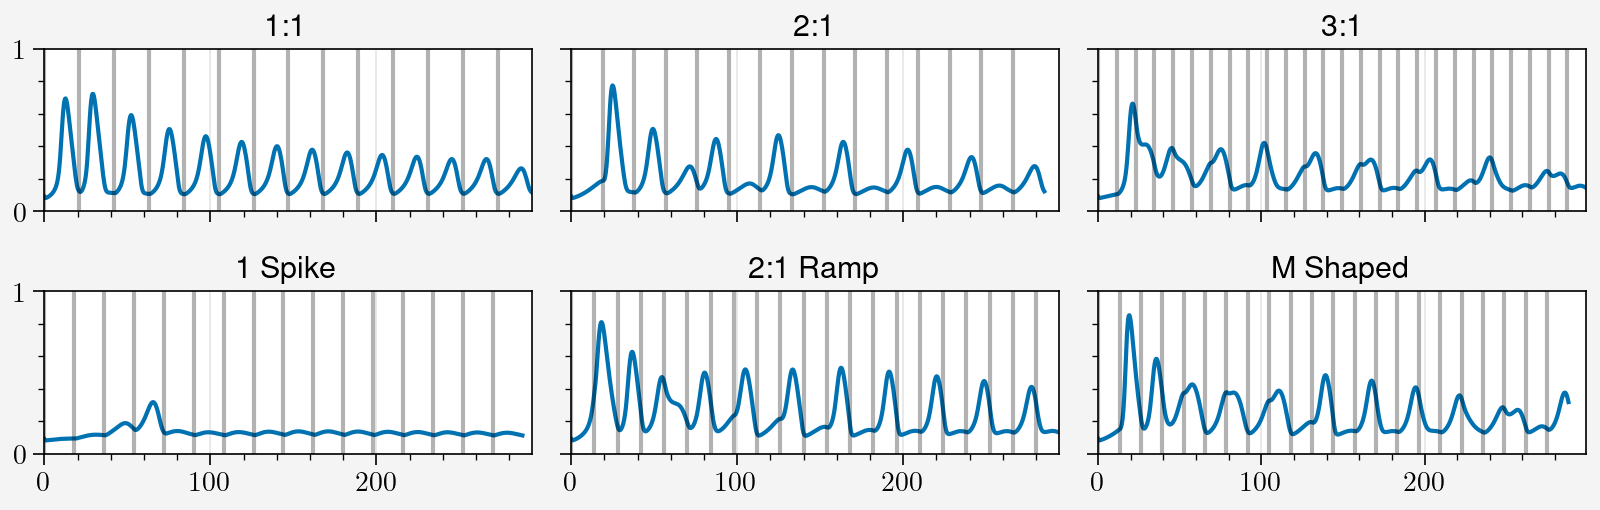

In [319]:
def plot_closest(glut, per, ax, num_spikes=14):
    glut_idx = np.argmax(gluts > glut)
    per_idx = np.argmax(periods > per)
    
    saved_glut = gluts[glut_idx]
    saved_per = periods[per_idx]
    key = f't{saved_per:.1f}p{saved_glut:.1f}'
    t, c = data[key]
    ax.plot(t, c)
    ax.text(0.8, 0.7, f'T{saved_per:.1f}$\phi${saved_glut:.1f}',
            transform='axes', ha='right')
    
    # Plot line
    line_x = [0]
    line_y = [0]
    cur_x = 0
    cur_y = 0
    for _ in range(num_spikes):
        line_x.append(cur_x)
        line_y.append(1-cur_y)
        cur_y = 1 - cur_y
        cur_x = cur_x + saved_per + 1
        line_x.append(cur_x)
        line_y.append(cur_y)
    ax.plot(line_x, np.array(line_y)*2-0.5, c='k', alpha=0.3)

    
    
def plot_spritz(glut, per, ax, num_spikes=None, max_t=None):
    if max_t is None and num_spikes is None:
        raise ValueError('One of num_spikes or max_t must be set')
    elif num_spikes is None:
        num_spikes = int(max_t / (per + 1))
    
    run_spritz(per, glut, num=num_spikes, osc_type=2)
    
    ax.plot(cfg.t, cfg.c)
    # ax.text(0.8, 0.7, f'T{per:.1f}$\phi${glut:.1f}',
    #         transform='axes', ha='right')

    # Plot line
    line_x = [0]
    line_y = [0]
    cur_x = 0
    cur_y = 0
    for _ in range(num_spikes):
        line_x.append(cur_x)
        line_y.append(1-cur_y)
        cur_y = 1 - cur_y
        cur_x = cur_x + per + 1
        line_x.append(cur_x)
        line_y.append(cur_y)
    ax.plot(line_x, np.array(line_y)*2-0.5, c='k', alpha=0.3)

fig, ax = pplt.subplots(nrows=2, ncols=3, refaspect=3, figwidth=8)

text_labels = [
    (16, 20, '1:1'),
    (11, 18, '2:1'),
    (8, 10.5, '3:1'),
    
    (5, 17, '1 Spike'),    
    (13, 13, '2:1 Ramp'),
    (11, 12.1, 'M Shaped'),
]

titles = []
for i, text in enumerate(text_labels):
    glut = text[0]
    per = text[1]
    title = text[2]
    
    plot_spritz(glut, per, ax[i], max_t=300)
    # titles.append(f'T={per}, $\phi$={glut}, {title}')
    titles.append(title)
    
ax.format(ylim=[0, 1], title=titles,
         yticks=[0, 1])


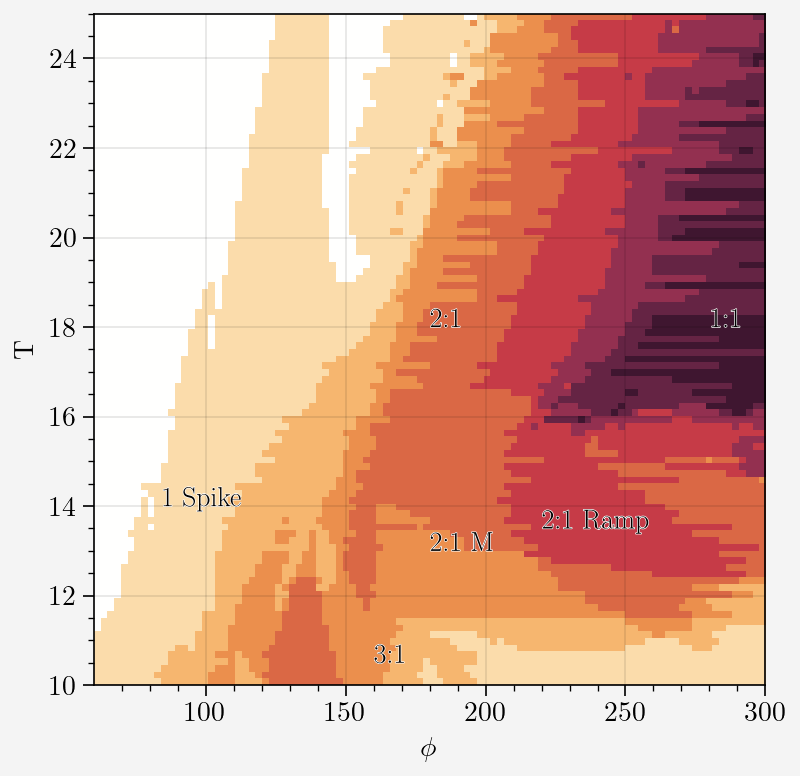

In [55]:
# data = pickle.load(open('data/spritz/12_spritz_summary', 'rb'))
# data = pickle.load(open('data/spritz/10_spritz_summary', 'rb'))
data = pickle.load(open('data/spritz/10_spritz_summary_50ms', 'rb'))

periods = np.linspace(10, 25, 100)
# gluts = np.linspace(3, 17, 100)
gluts = np.linspace(60, 300, 100)

fig, ax = pplt.subplots(figwidth=4)
hm = []
for period in periods:
    row = []
    for glut in gluts:
        key = f't{period:.1f}p{glut:.1f}'
        # c = data[key]
        t, c = data[key]
        peaks = evaluate_peaks(c=c, t=t, cutoff_peak=0.3, cutoff_trough=0.2,
                              period=period, skip_first=2)
        row.append(len(peaks))
    hm.append(row)
hm = np.flip(hm, axis=0)


# c = ax.imshow(hm, extent=(3, 17, 10, 25), aspect='equal')
c = ax.imshow(hm, extent=(60, 300, 10, 25), aspect=16)

text_labels = [
    (14, 18, '1:1'),
    (9, 18, '2:1'),
    (8, 10.5, '3:1'),
    (9, 13, 'M Shaped'),
    (4.2, 14, '1 Spike'),
    (12, 12.5, '2:1 Ramp')
]
text_labels = [
    (280, 18, '1:1'),
    (180, 18, '2:1'),
    (160, 10.5, '3:1'),
    (180, 13, '2:1 M'),
    (84, 14, '1 Spike'),
    (220, 13.5, '2:1 Ramp')
]

for text in text_labels:
    txt = ax.text(text[0], text[1], text[2], c='black', fontweight='1000')
    txt.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='white'), path_effects.Normal()])

ax.format(xlabel='$\phi$', ylabel='T')

# fig.savefig('data/spritz/annotate_10.jpg')

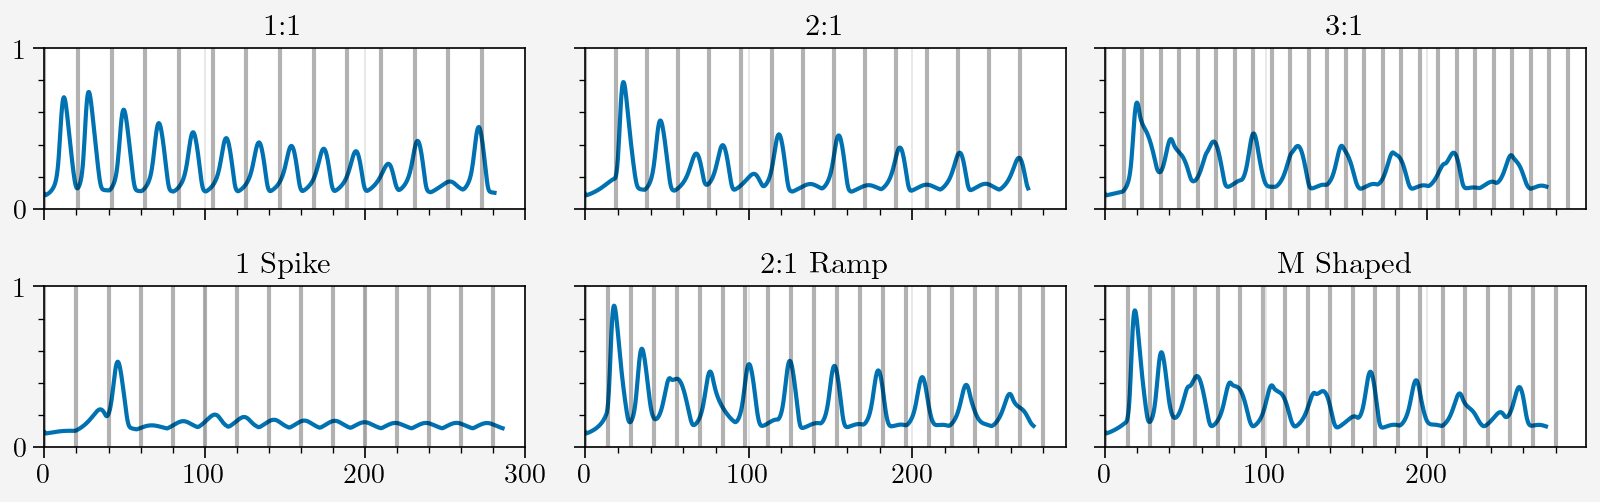

In [51]:
def plot_spritz(glut, per, ax, num_spikes=None, max_t=None,
                dur=1):
    if max_t is None and num_spikes is None:
        raise ValueError('One of num_spikes or max_t must be set')
    elif num_spikes is None:
        num_spikes = int(max_t / (per + 1))
    
    run_spritz(per, glut, num=num_spikes, osc_type=2, dur=dur)
    
    ax.plot(cfg.t, cfg.c)
    # ax.text(0.8, 0.7, f'T{per:.1f}$\phi${glut:.1f}',
    #         transform='axes', ha='right')

    # Plot line
    line_x = [0]
    line_y = [0]
    cur_x = 0
    cur_y = 0
    for _ in range(num_spikes):
        line_x.append(cur_x)
        line_y.append(1-cur_y)
        cur_y = 1 - cur_y
        cur_x = cur_x + per + 1
        line_x.append(cur_x)
        line_y.append(cur_y)
    ax.plot(line_x, np.array(line_y)*2-0.5, c='k', alpha=0.3)

fig, ax = pplt.subplots(nrows=2, ncols=3, refaspect=3, figwidth=8)

# text_labels = [
#     (16, 20, '1:1'),
#     (11, 18, '2:1'),
#     (8, 10.5, '3:1'),
    
#     (5, 17, '1 Spike'),    
#     (13, 13, '2:1 Ramp'),
#     (11, 12.1, 'M Shaped'),
# ]
text_labels = [
    (320, 20, '1:1'),
    (220, 18, '2:1'),
    (160, 10.5, '3:1'),
    
    (100, 17, '1 Spike'),    
    (240, 13, '2:1 Ramp'),
    (220, 13, 'M Shaped'),
]

titles = []
for i, text in enumerate(text_labels):
    glut = text[0]
    per = text[1]
    title = text[2]
    
    plot_spritz(glut, per, ax[i], max_t=300, dur=0.05)
    # titles.append(f'T={per}, $\phi$={glut}, {title}')
    titles.append(title)
    
ax.format(ylim=[0, 1], title=titles,
         yticks=[0, 1])


### Examine a section closer

Change x and y coordinates given in the variable closest, then run the next block to see what experiments fell in that block

<a list of 1 Line2D objects>

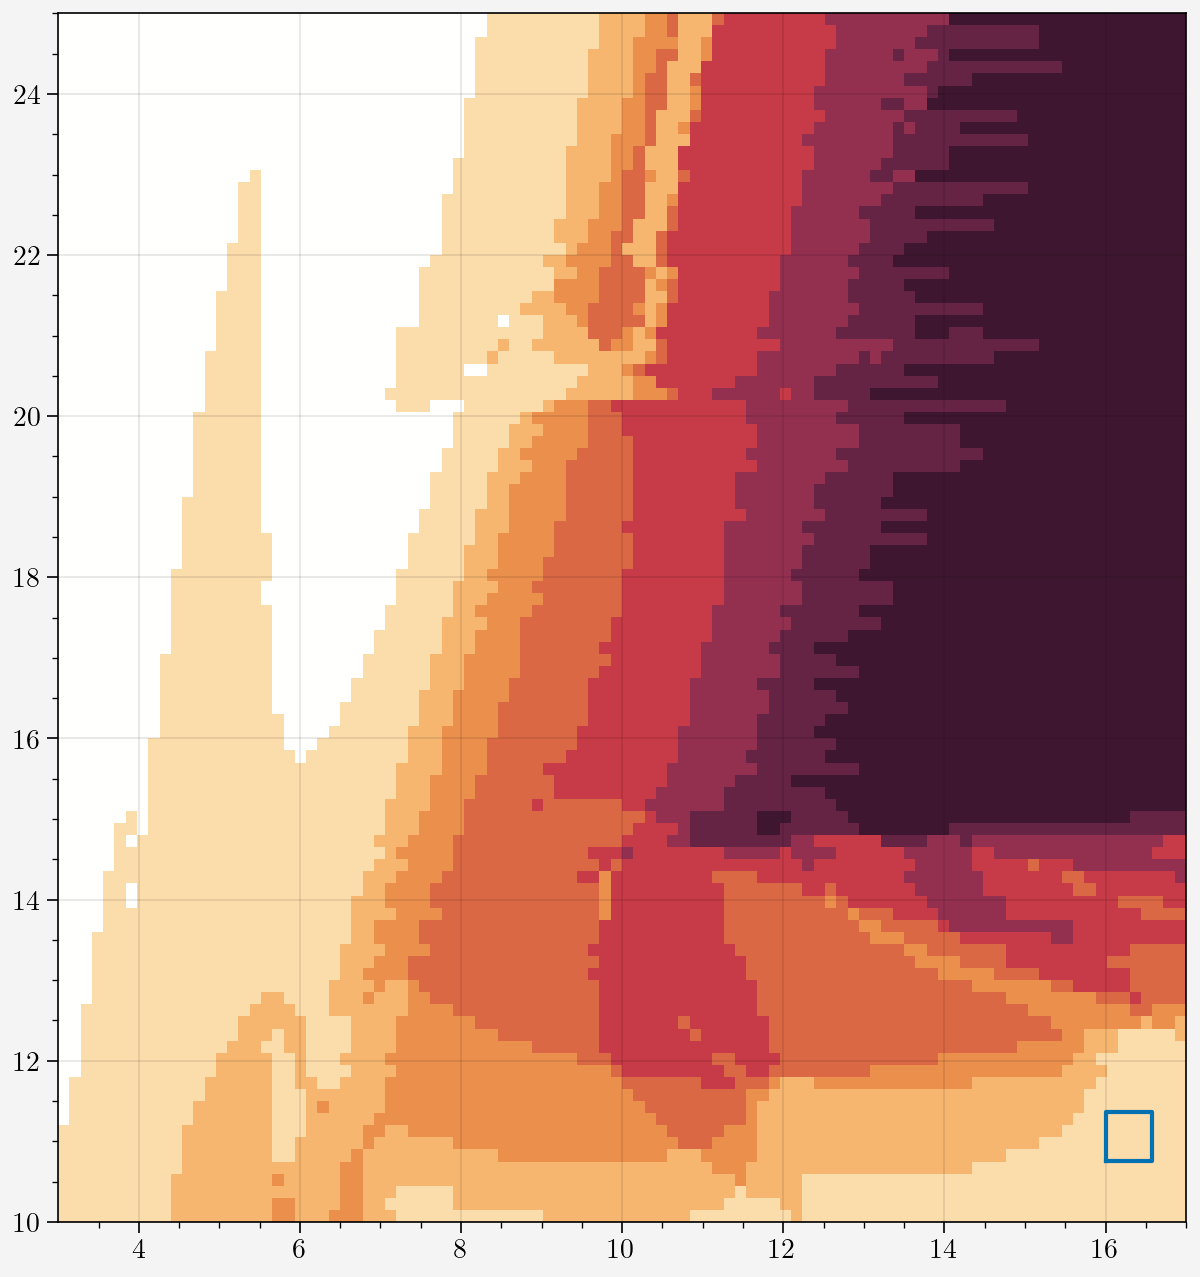

In [207]:
fig, ax = pplt.subplots(figwidth=6)
ax.imshow(hm, extent=(3, 17, 10, 25), aspect='equal')

closest = [16, 10.7]

# find closest x
glut_idx = np.argmax(gluts > closest[0])
per_idx = np.argmax(periods > closest[1])

glut1 = gluts[glut_idx]
glut2 = gluts[glut_idx + 4]
per1 = periods[per_idx]
per2 = periods[per_idx + 4]

ax.plot([glut1, glut1, glut2, glut2, glut1], 
        [per1, per2, per2, per1, per1])

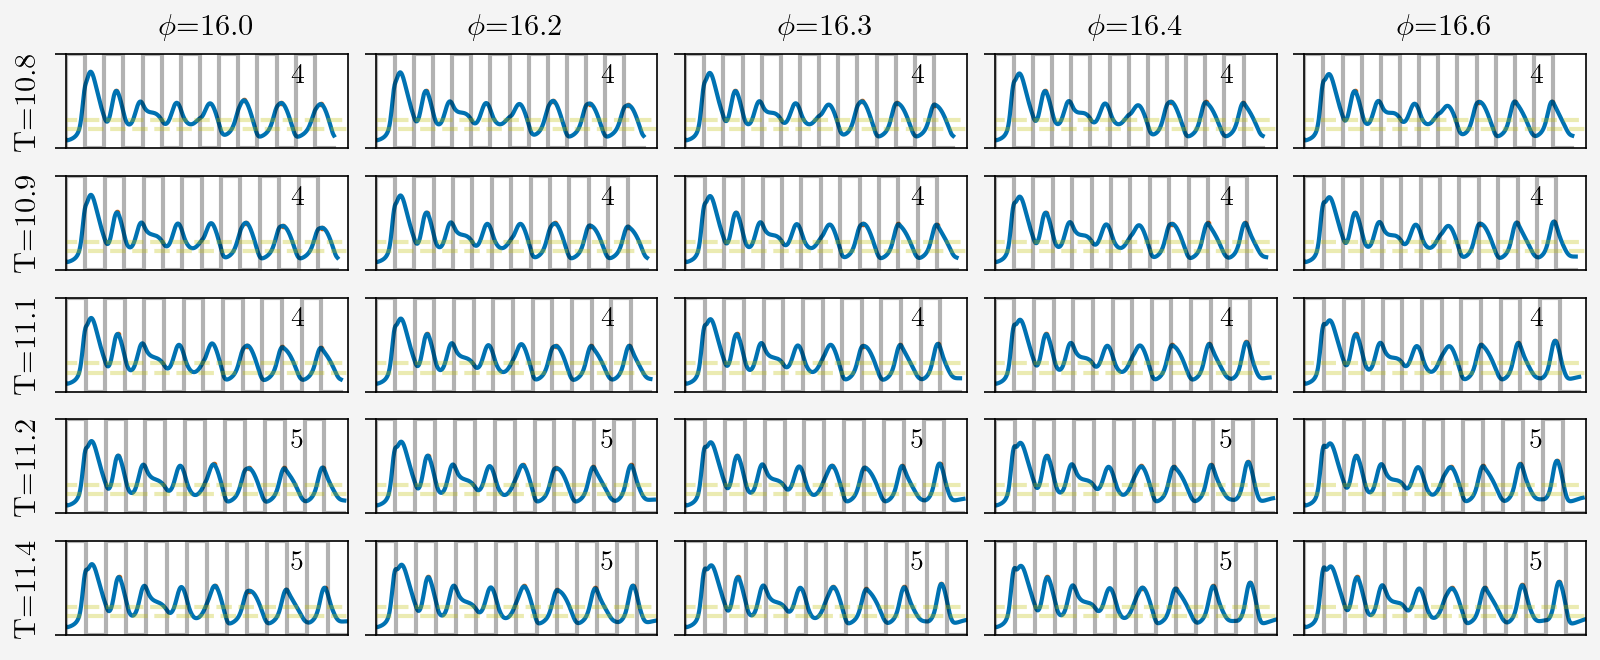

In [208]:
gluts2 = gluts[glut_idx:glut_idx+5]
periods2 = periods[per_idx:per_idx+5]

fig, ax = pplt.subplots(nrows=m, ncols=n, refaspect=3, wspace=1, hspace=1,
                        figwidth=8)
num_spikes = 14
for i, period in enumerate(periods2):
    for j, glut in enumerate(gluts2):
        # key = f't{period:.1f}p{glut:.1f}'
        # t, c = data[key]
        
        run_spritz(period=period, conc=glut, num=num_spikes, osc_type=2)
        ax[i, j].plot(cfg.t, cfg.c)
        
        # Generate lines to show where spikes occur
        line_x = [0]
        line_y = [0]
        cur_x = 0
        cur_y = 0
        for _ in range(num_spikes):
            line_x.append(cur_x)
            line_y.append(1-cur_y)
            cur_y = 1 - cur_y
            cur_x = cur_x + period + 1
            line_x.append(cur_x)
            line_y.append(cur_y)
        ax[i, j].plot(line_x, line_y, c='k', alpha=0.3)
        ax[i, j].plot([0, 1000, 1000, 0], [0.2, 0.2, 0.3, 0.3], c='y', alpha=0.3, linestyle='--',)
        peaks = evaluate_peaks(cutoff_peak=0.3, period=period, skip_first=2)
        ax[i, j].text(0.8, 0.7, len(peaks), transform='axes')
        ax[i, j].scatter(cfg.t[peaks], cfg.c[peaks], markersize=2)
        
        
ax.format(yticklabels=[], xticks=[],
         leftlabels=[f'T={period:.1f}' for period in periods2],
         toplabels=[f'$\phi$={glut:.1f}' for glut in gluts2],
         ylim=[0, 1], xlim=[0, (periods2[-1]+1)*14])
